## Assess the novelty of the Li Dataset

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from distance import *
from mi_density import *
from utils import *

from pymatgen.core import Structure

import textalloc as ta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 10
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#348ABD",
        "#A60628",
        "#7A68A6",
        "#467821",
    ]
)

colors = [
    '#348abd',  # Start color
    '#4c7dc1',
    '#696ebd',
    '#865baf',
    '#9c4497',
    '#aa2a76',
    '#ae0d50',
    '#a60628'   # End color
]
n_bins = 256
cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

import warnings
warnings.filterwarnings("ignore")

/Users/andrewf/miniconda3/envs/DISCOVERII_clone/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load formulas and structures from dataset folder.

In [2]:
MAT_DB = 'MP_Li_dataset'

structures = []
formulas = []
files = os.listdir(MAT_DB)
files = [file for file in files if ".cif" in file]
for filename in files:
    structure = Structure.from_file(os.path.join(MAT_DB, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))

mp = np.ones((len(structures)))

data = pd.DataFrame({'formula': formulas, 'structure': structures, 'filename': files, 'mp': mp})

MAT_DB = 'GNOME_Li_dataset'

structures = []
formulas = []
files = os.listdir(MAT_DB)
files = [file for file in files if ".cif" in file]
for filename in files:
    structure = Structure.from_file(os.path.join(MAT_DB, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))

mp = np.zeros((len(structures)))

# append to the data
data = pd.concat([data, pd.DataFrame({'formula': formulas, 'structure': structures, 'filename': files, 'mp': mp})], ignore_index=True)

### Load the distance matrices.

Optionally, you can re-generate them from the data (you might want to go make some coffee while you wait).

In [3]:
use_precomputed = True

if use_precomputed:
    lostop_dm = np.load("precomputed/Li_lostop_dm.npy")
    elmd_dm = np.load("precomputed/Li_elmd_dm.npy")
else:
    lostop_dm = get_lostop_dm(data["structure"].values)
    np.save("precomputed/Li_lostop_dm.npy", lostop_dm)

    elmd_dm = get_elmd_dm(data["formula"].values)
    np.save("precomputed/Li_elmd_dm.npy", elmd_dm)

### Compute the densities of GNOME materials against the MP corpus.

In [4]:
df = pd.DataFrame()
mi_data = {}

GNOME_idx = data[data['mp'] == 0].index
MP_idx = data[data['mp'] == 1].index

for dm, name in zip([lostop_dm, elmd_dm], ["lostop", "elmd"]):

    # only select rows and columns associated with MP materials
    filtered_dm = dm.copy()
    filtered_dm = filtered_dm[MP_idx][:, MP_idx]

    cutoff, mi_profile = get_MI_profile(filtered_dm, n_thresholds=200)
    mi_data[name] = [cutoff, mi_profile]

    print(f"MI cutoff for {name}: {cutoff}")

    dens = compute_mi_density(filtered_dm, cutoff, mi_profile)

    # now iteratively add the GNOME materials to the density matrix and append their density
    for G_idx in GNOME_idx:
        filtered_dm = dm.copy()
        # drop every other GNOME material except the one we are interested in from row and column
        filtered_dm = np.delete(filtered_dm, GNOME_idx[GNOME_idx != G_idx], axis=0)
        filtered_dm = np.delete(filtered_dm, GNOME_idx[GNOME_idx != G_idx], axis=1)

        dens_G = compute_mi_density(filtered_dm, cutoff, mi_profile)
        dens = np.concatenate((dens, np.array([dens_G[-1]])))

    df[f'{name}_density'] = dens

df['formula'] = data['formula']

MI cutoff for lostop: 2.4367534301084146
MI cutoff for elmd: 18.255648919597988


### Plot material densities along chemical and structural axes.

Note that the publication figure was adjusted post-hoc for visual clarity due to positioning issues with the `textalloc` library.

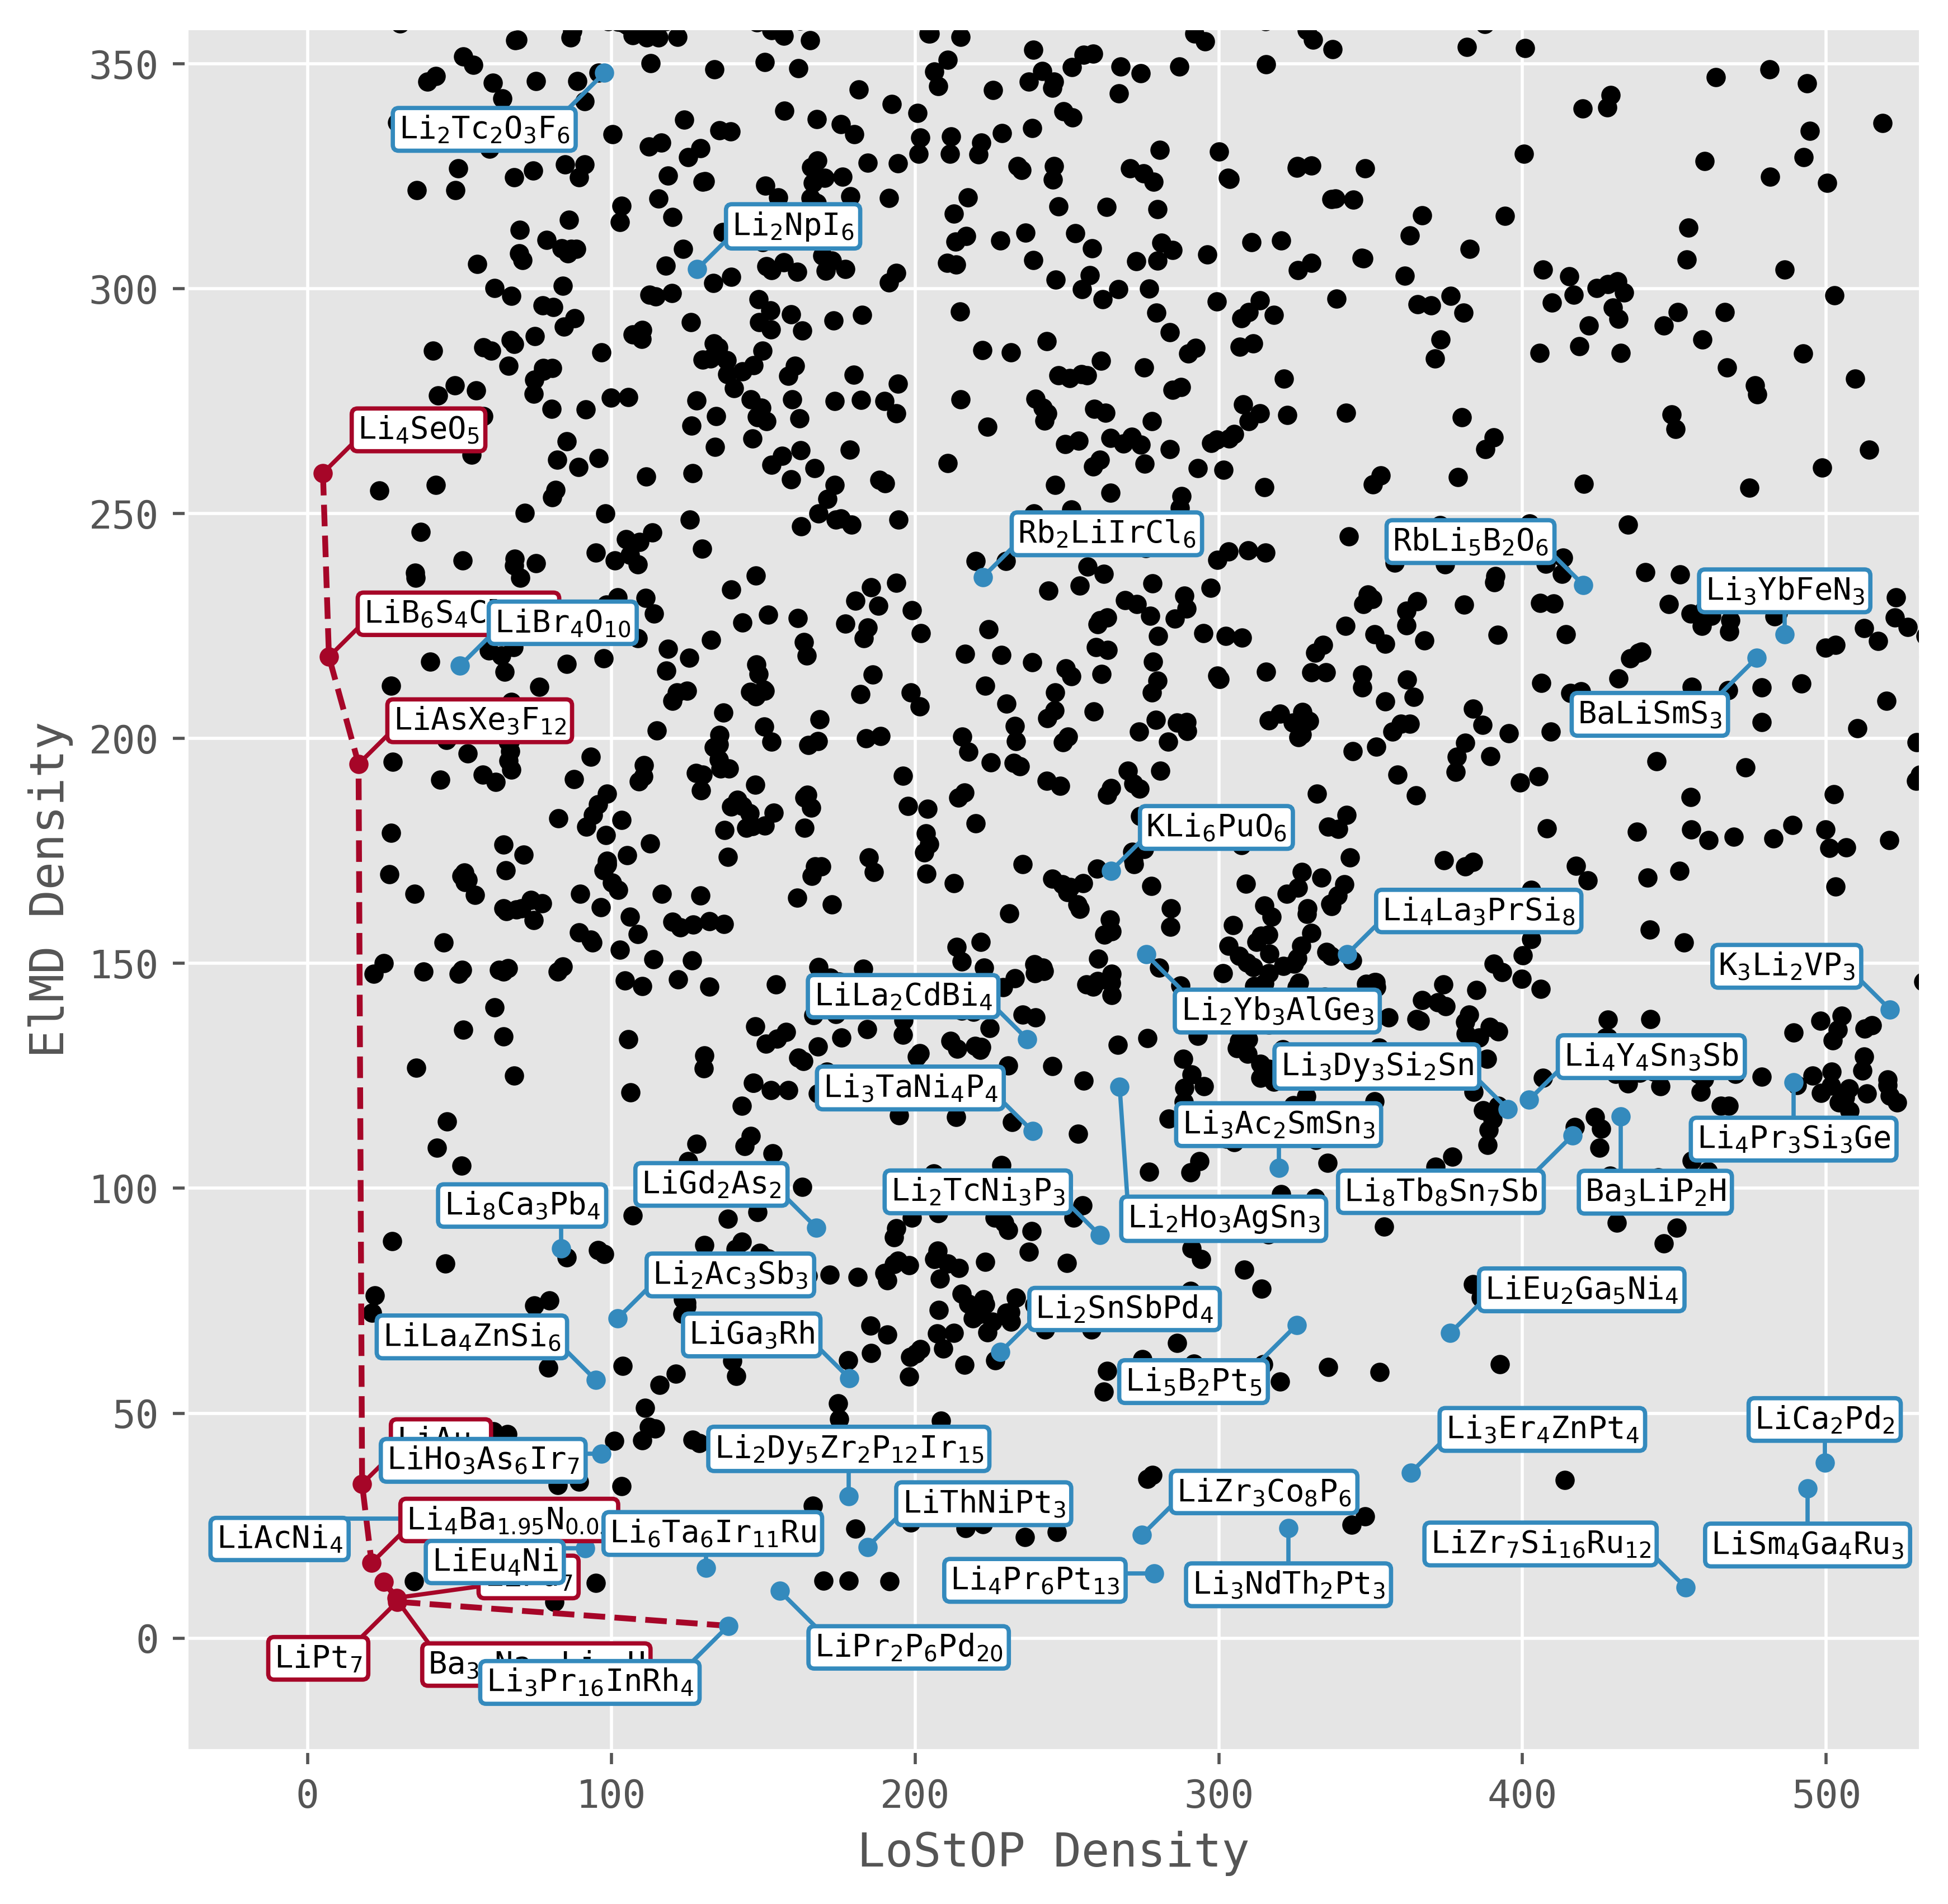

In [5]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=500)

p_idx = is_pareto_efficient(df[['lostop_density', 'elmd_density']].values, return_mask=False)

G_idx = np.where(data['mp'] == 0)[0]

# Plot all points
for i in range(len(df)):
    ax.scatter(
        df['lostop_density'].iloc[i],
        df['elmd_density'].iloc[i],
        color='C1' if i in p_idx and i not in G_idx else 'C0' if i in G_idx else 'k',
        s=20,
        zorder=10 if i in G_idx else 1,
    )


plt.xlim(-40, np.max(df.loc[G_idx, 'lostop_density']) + 10)
plt.ylim(-25, np.max(df.loc[G_idx, 'elmd_density']) + 10)
# plt.xlim(-40, 710)
# plt.ylim(-25, 500)

pareto_x = df['lostop_density'].loc[p_idx]
pareto_y = df['elmd_density'].loc[p_idx]

# sort by pareto_y
pareto_x, pareto_y = zip(*sorted(zip(pareto_x, pareto_y), key=lambda pair: pair[1]))

ax.plot(pareto_x, pareto_y, color='C1', lw=1.5, ls='--', marker='None')

# now I want to label the pareto points and the GNOME points

labels = [reduce_single_formula(formula) for formula in df['formula'].values]
# if filename has "[" in it, prepend the text within "[ ]"
for i, label in enumerate(labels):
    if "[" in data['filename'].values[i]:
        labels[i] = "$_{" + data['filename'].values[i].split(']')[0].split('[')[1] + "}$" + str(label)

# if any p_idx is in G_idx, remove it
p_idx = np.array([i for i in p_idx if i not in G_idx])

pareto_labels = [labels[i] for i in p_idx]

pareto_labels[1] = "Li$_{4}$Ba$_{1.95}$N$_{0.05}$"
pareto_labels[6] = "Ba$_{38}$Na$_{58}$Li$_{26}$H"

ta.allocate(ax,
            x=df['lostop_density'].loc[p_idx],
            y=df['elmd_density'].loc[p_idx],
            text_list=pareto_labels,
            x_scatter=df['lostop_density'].loc[p_idx].values,
            y_scatter=df['elmd_density'].loc[p_idx].values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            margin=0.012,
            textsize=8,
            nbr_candidates=10000,
            linecolor='C1',
            linewidth=1.1,
            min_distance=0.02,
            # max_distance=0.03,
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="C1", pad=0.19, lw=1.1),
            zorder=25,
            )

GNOME_labels = [labels[i] for i in G_idx]

ta.allocate(ax,
            x=df['lostop_density'].loc[G_idx],
            y=df['elmd_density'].loc[G_idx],
            text_list=GNOME_labels,
            x_scatter=df['lostop_density'].loc[G_idx].values,
            y_scatter=df['elmd_density'].loc[G_idx].values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            margin=0.012,
            textsize=8,
            # verticalalignment='top',
            nbr_candidates=10000,
            linecolor='C0',
            linewidth=1.1,
            min_distance=0.02,
            # max_distance=0.03,
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="C0", pad=0.19, lw=1.1),
            zorder=25,
            )

# Set labels
plt.rcParams['svg.fonttype'] = 'none'
ax.set_xlabel("LoStOP Density")
ax.set_ylabel("ElMD Density")
plt.show()